 # Count And Identify Trees

In [1]:
import rasterio
from rasterio.transform import from_origin
from rasterio.windows import Window
from deepforest import main
from deepforest import utilities
import ffmpeg
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class SrtParser:
    def __init__(self,path):
        self.path = path
        file_to_read = open(path,'r')
        self.data = file_to_read.read()
        file_to_read.close()
        self.subtitles = pd.DataFrame(columns=['index','start','end','text','latitude','longitude','distance','height','horizontal_speed','vertical_speed'])

    def parseTime(self,time_str):
        # Extract hours, minutes, and seconds from the time string
        hours, minutes, seconds_milliseconds = time_str.split(':')
        seconds, milliseconds = seconds_milliseconds.split(',')
        
        # Convert hours, minutes, and seconds to integers
        hours = int(hours)
        minutes = int(minutes)
        seconds = int(seconds)
        milliseconds = int(milliseconds)
        
        # Return the total number of milliseconds
        return (hours * 3600 + minutes * 60 + seconds) * 1000 + milliseconds


    def parseSubtitle(self,subtitle_str):
        # Split the subtitle string into lines
        lines = subtitle_str.strip().split('\n')
        
        # Extract the index, start, and end times from the first line
        index = int(lines[0])
        start, end = map(self.parseTime, lines[1].split(' --> '))
        
        # Join the remaining lines into a single string
        text = '\n'.join(lines[2:])
        
        # Create and return a Subtitle object
        new_subtitle = pd.DataFrame.from_dict({
            'index': [index],
            'start': [start],
            'end': [end],
            'text': [text],
            'longitude': [float(text.split(',')[4].lstrip('GPS ('))],
            'latitude': [float(text.split(',')[5])],
            'distance': [float(text.split(',')[7].lstrip('D ').rstrip('m'))],
            'height': [float(text.split(',')[8].lstrip('H ').rstrip('m'))],
            'horizontal_speed': [float(text.split(',')[9].lstrip('H.S ').rstrip('m/s'))],
            'vertical_speed': [float(text.split(',')[10].lstrip('V.S ').rstrip('m/s'))]
        })
        self.subtitles = pd.concat([self.subtitles,new_subtitle],ignore_index=True)

    def parseSrt(self,srt_str):
        # Split the srt string into a list of subtitle strings
        subtitles = re.split('\n\n+', srt_str.strip())
        
        # Parse each subtitle string and return a list of Subtitle objects
        for subtitle in subtitles:
            self.parseSubtitle(subtitle)
        return self.subtitles
    
    def parse(self):
        return self.parseSrt(self.data)

In [3]:
def prepareEnv(envName):
    #If a path or filename is provided the env name is the basename of the given filename.
    envName = os.path.basename(envName).split('.')[0]

    if not os.path.exists('data'):
        os.makedirs('data')
    envPath = 'data/%s'%envName
    if not os.path.exists(envPath):
        os.makedirs(envPath)
    srcImgsPath = '%s/srcImgs'%envPath
    if not os.path.exists(srcImgsPath):
        os.makedirs(srcImgsPath)
    geoImgsPath = '%s/geoImgsPath'%envPath
    if not os.path.exists(geoImgsPath):
        os.makedirs(geoImgsPath)

    config = {
        'envName': envName,
        'envPath': envPath,
        'srcImgsPath': srcImgsPath,
        'geoImgsPath': geoImgsPath,
        'metaSrtFile': '%s/subs.srt' % envPath,
        'srcImgsFile': '%s/%s'%(srcImgsPath,"src_%05d.png")
    }

    return config


In [4]:

def extractMetaFromVideo(videoFileName): 
    config = prepareEnv(videoFileName)
    ffmpeg.input(videoFileName).output(config['metaSrtFile'], map = "0:s:0").run(overwrite_output=True)

In [5]:
def createSrcImgs(videoFileName):
    config = prepareEnv(videoFileName)
    ffmpeg.input(videoFileName).output(config['srcImgsFile'],r=1).run(overwrite_output=True)

In [6]:
def generateGeoCodeImage(videoFileName,second,latidute,longitude):
    config = prepareEnv(videoFileName)
    src = rasterio.open('%s/src_%05d.png'%(config['srcImgsPath'],second))
    width, height = src.width, src.height
    size = min(width, height)

    # Set the metadata for the GeoTIFF
    meta = {
        'driver': 'GTiff',
        'dtype': 'uint8',
        'nodata': 0,
        'width': size,
        'height': size,
        'count': 3,
        'crs': rasterio.crs.CRS.from_epsg(4326),  # Set the CRS to EPSG: 4326 (WGS 84)
        'transform': from_origin(latidute, longitude, 0.1, 0.1)  # Set the latitude and longitude coordinates as the origin
    }

    # Create the GeoTIFF file
    with rasterio.open('%s/geo_%05d.tiff'%(config['geoImgsPath'],second), 'w', **meta) as dst:
        x_offset = (width - size) // 2
        y_offset = (height - size) // 2
        window = Window(x_offset, y_offset, size, size)

        # Copy the data from the source image to the GeoTIFF
        dst.write(src.read(window=window))

    src.close()

In [7]:
class DeepForestWrapper:
    def __init__(self):
        self.main = main.deepforest()
        self.main.use_release(check_release=False)
        
    def predict(self,videoFileName,second):
        config = prepareEnv(videoFileName)
        path = '%s/geo_%05d.tiff'%(config['geoImgsPath'],second)
        r = rasterio.open(path)
        transform = r.transform 
        crs = r.crs
        r.close()

        df = self.main.predict_image(path=path)
        gdf = utilities.annotations_to_shapefile(df, transform=transform, crs=crs)
        return gdf
    
    def plot(self,videoFileName,second):
        config = prepareEnv(videoFileName)
        path = '%s/geo_%05d.tiff'%(config['geoImgsPath'],second)
        return self.main.predict_image(path=path,return_plot=True,thickness=5)

In [8]:
videoFileName = "/Users/hakanonal/Downloads/temp_video_for_share.mp4"
config = prepareEnv(videoFileName)

In [9]:
extractMetaFromVideo(videoFileName)

ffmpeg version N-109428-g10a56363a7-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static

In [10]:
srtParser = SrtParser(config['metaSrtFile'])
metaData = srtParser.parse()
metaData

,index,start,end,text,latitude,longitude,distance,height,horizontal_speed,vertical_speed
0,1,0,1000,"F/2.8, SS 1092.75, ISO 110, EV 0, GPS (28.0279...",38.5969,28.0279,23.50,2.9,0.00,0.0
1,2,1000,2000,"F/2.8, SS 1092.75, ISO 110, EV 0, GPS (28.0279...",38.5969,28.0279,23.45,2.9,0.20,0.0
2,3,2000,3000,"F/2.8, SS 1092.75, ISO 110, EV 0, GPS (28.0279...",38.5969,28.0279,23.79,2.9,0.71,0.0
3,4,3000,4000,"F/2.8, SS 1092.75, ISO 110, EV 0, GPS (28.0279...",38.5969,28.0279,24.69,2.9,1.41,0.0
4,5,4000,5000,"F/2.8, SS 1122.74, ISO 110, EV 0, GPS (28.0279...",38.5969,28.0279,26.19,2.8,2.02,0.0
...,...,...,...,...,...,...,...,...,...,...
306,307,306000,307000,"F/2.8, SS 242.51, ISO 100, EV 0, GPS (28.0274,...",38.5964,28.0274,57.10,32.4,1.63,0.0
307,308,307000,308000,"F/2.8, SS 242.51, ISO 100, EV 0, GPS (28.0274,...",38.5964,28.0274,55.54,32.4,1.63,0.0
308,309,308000,309000,"F/2.8, SS 242.51, ISO 100, EV 0, GPS (28.0274,...",38.5964,28.0274,53.98,32.4,1.61,0.0
309,310,309000,310000,"F/2.8, SS 245.15, ISO 100, EV 0, GPS (28.0274,...",38.5964,28.0274,52.44,32.5,1.63,0.0


In [ ]:
#createSrcImgs(videoFileName)

Reading config file: /Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/data/deepforest_config.yml


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransf

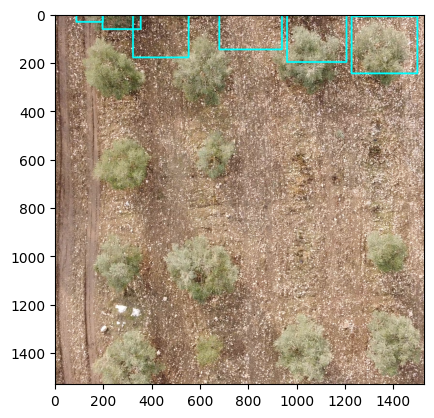

In [11]:
ai = DeepForestWrapper()
for i in range(190,200):
    generateGeoCodeImage(videoFileName,i,metaData.latitude[i],metaData.longitude[i])
    img = ai.plot(videoFileName,i)
    plt.imshow(img[:,:,::-1])